# Vine Fungi Detect: Binary Classification

In [ ]:
!pip install datasets==2.14.5 transformers torch

In [ ]:
import os
from pathlib import Path
import torch
from torch.utils.data import Dataset
from PIL import Image
from datasets import Dataset, Features, ClassLabel, Image as HFImage
from transformers import (
    ViTFeatureExtractor,
    ViTForImageClassification,
    TrainingArguments,
    Trainer
)
import numpy as np
from datasets import load_metric
from sklearn.metrics import f1_score, classification_report

import matplotlib.pyplot as plt
from PIL import Image
import random

## Dataset Name: An Eye on the Vine  

Based on the research paper, the authors created and used several datasets to address the problem of pathogen segmentation in vinewood fluorescence microscopy images.  

## Dataset Description  

### Dataset A  
Contains **427 synthetic images** that were generated following the procedure detailed in Section 2.2. These synthetic images were created by:  
- Selecting snippets from healthy wood images  
- Selecting same-sized snippets from the **DRIVE** database (*Digital Retinal Images for Vessel Extraction*)  
- Sampling a **Gaussian Markov Random Field (GMRF)** realization  
- Blending the images according to a given target **Signal-to-Noise Ratio (SNR)**  

### Dataset B  
Contains **real fluorescence microscopy images** with expert-labeled ground truths, split into:  
- **B1**: 247 images with fungi in lower quality images (*higher blur*)  
- **B2**: 312 images without fungi  
- **B3**: 569 images with fungi  

### Dataset C  
Contains **128 mixed images** from datasets **A, B1, and B3**  

For this task, we have used **B2 AND B3** from Dataset B.  

## Dataset Availability  
The dataset is available at:  
[An Eye on the Vine - A Dataset for Fungi Segmentation in Microscopy Images](https://archive.ics.uci.edu/dataset/966/an+eye+on+the+vine+-+a+dataset+for+fungi+segmentation+in+mi)  


In [ ]:
def visualize_fungi_samples(data_dir, num_samples=4):
    """
    Visualize sample images from both classes in the fungi dataset

    Parameters:
    data_dir (str): Path to the dataset directory
    num_samples (int): Number of samples to visualize per class
    """
    data_dir = Path(data_dir)
    classes = ['No Fungi', 'Fungi']

    # Create a figure with subplots
    fig, axes = plt.subplots(2, num_samples, figsize=(16, 8))
    fig.suptitle('Sample Images from Fungi Dataset', fontsize=16)

    # Loop through each class
    for class_idx, class_name in enumerate(classes):
        # Get paths to all images in this class
        class_dir = data_dir / class_name
        image_paths = list(class_dir.glob('*.tif'))

        # Select random samples
        selected_samples = random.sample(image_paths, min(num_samples, len(image_paths)))

        # Plot each sample
        for i, img_path in enumerate(selected_samples):
            with Image.open(img_path) as img:
                # Convert to RGB as some images might be grayscale
                if img.mode != 'RGB':
                    img = img.convert('RGB')

                # Display the image
                axes[class_idx, i].imshow(img)
                axes[class_idx, i].set_title(f"{class_name}\n{img_path.name}")
                axes[class_idx, i].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

Visualizing sample images...


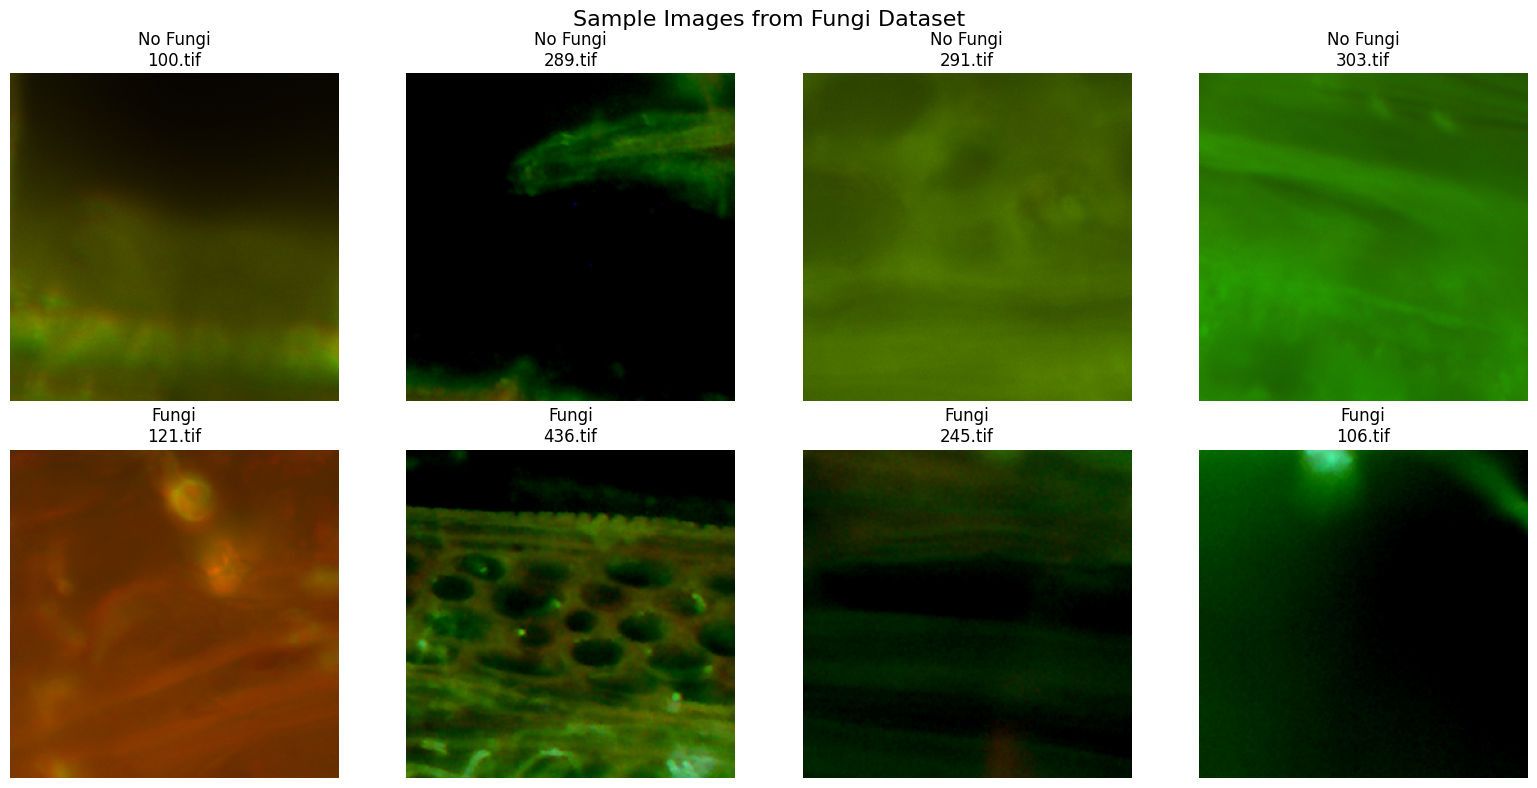

In [ ]:
data_dir = "/kaggle/input/an-eye-on-the-vine/an_eye_on_the_vine"

# Run the visualizations
print("Visualizing sample images...")
visualize_fungi_samples(data_dir, num_samples=4)

In [ ]:
def analyze_image_properties(data_dir):
    """
    Analyze basic properties of the images in the dataset

    Parameters:
    data_dir (str): Path to the dataset directory
    """
    data_dir = Path(data_dir)
    classes = ['No Fungi', 'Fungi']

    # Initialize counters and data collectors
    class_counts = {}
    image_sizes = []
    image_modes = {}

    sample_size = 150
    print(f'Testing on {sample_size * 2} sample images.')
    print('')
    # Loop through each class
    for class_name in classes:
        class_dir = data_dir / class_name
        image_paths = list(class_dir.glob('*.tif'))
        class_counts[class_name] = len(image_paths)

        # Analyze a sample of images from each class
        samples = random.sample(image_paths, min(sample_size, len(image_paths)))
        for img_path in samples:
            with Image.open(img_path) as img:
                # Record image size
                image_sizes.append(img.size)

                # Record image mode
                if img.mode in image_modes:
                    image_modes[img.mode] += 1
                else:
                    image_modes[img.mode] = 1

    # Print analysis results
    print("Dataset Analysis:")
    print("=" * 35)
    print(f"Total classes: {len(classes)}")
    print("")
    print("Class distribution:")
    for class_name, count in class_counts.items():
        print(f"  - {class_name}: {count} images")
    print("")
    # Analyze image sizes
    if image_sizes:
        unique_sizes = set(image_sizes)
        print(f"Unique image sizes: {len(unique_sizes)}")
        for size in unique_sizes:
            count = image_sizes.count(size)
            print(f"  - {size}: {count} images")
    print("")
    # Analyze image modes
    print("Image color modes:")
    for mode, count in image_modes.items():
        print(f"  - {mode}: {count} images")

In [ ]:
print("\nAnalyzing image properties...\n")
analyze_image_properties(data_dir)


Analyzing image properties...

Testing on 300 sample images.

Dataset Analysis:
Total classes: 2

Class distribution:
  - No Fungi: 312 images
  - Fungi: 569 images

Unique image sizes: 1
  - (256, 256): 300 images

Image color modes:
  - RGB: 300 images


In [ ]:
def plot_color_histograms(data_dir, num_samples=3):
    """
    Plot RGB histograms for sample images from each class

    Parameters:
    data_dir (str): Path to the dataset directory
    num_samples (int): Number of samples to analyze per class
    """
    data_dir = Path(data_dir)
    classes = ['No Fungi', 'Fungi']

    fig, axes = plt.subplots(2, num_samples, figsize=(16, 10))
    fig.suptitle('RGB Histograms of Sample Images', fontsize=16)

    # Loop through each class
    for class_idx, class_name in enumerate(classes):
        class_dir = data_dir / class_name
        image_paths = list(class_dir.glob('*.tif'))
        selected_samples = random.sample(image_paths, min(num_samples, len(image_paths)))

        # For each sample, plot the histogram
        for i, img_path in enumerate(selected_samples):
            with Image.open(img_path) as img:
                # Convert to RGB
                if img.mode != 'RGB':
                    img = img.convert('RGB')

                img_array = np.array(img)
                ax = axes[class_idx, i]

                # Plot histograms for each channel
                ax.hist(img_array[:,:,0].flatten(), bins=50, color='r', alpha=0.5, label='Red')
                ax.hist(img_array[:,:,1].flatten(), bins=50, color='g', alpha=0.5, label='Green')
                ax.hist(img_array[:,:,2].flatten(), bins=50, color='b', alpha=0.5, label='Blue')

                ax.set_title(f"{class_name}\n{img_path.name}")
                ax.legend()
                ax.set_xlabel('Pixel Value')
                ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()


Plotting color histograms...


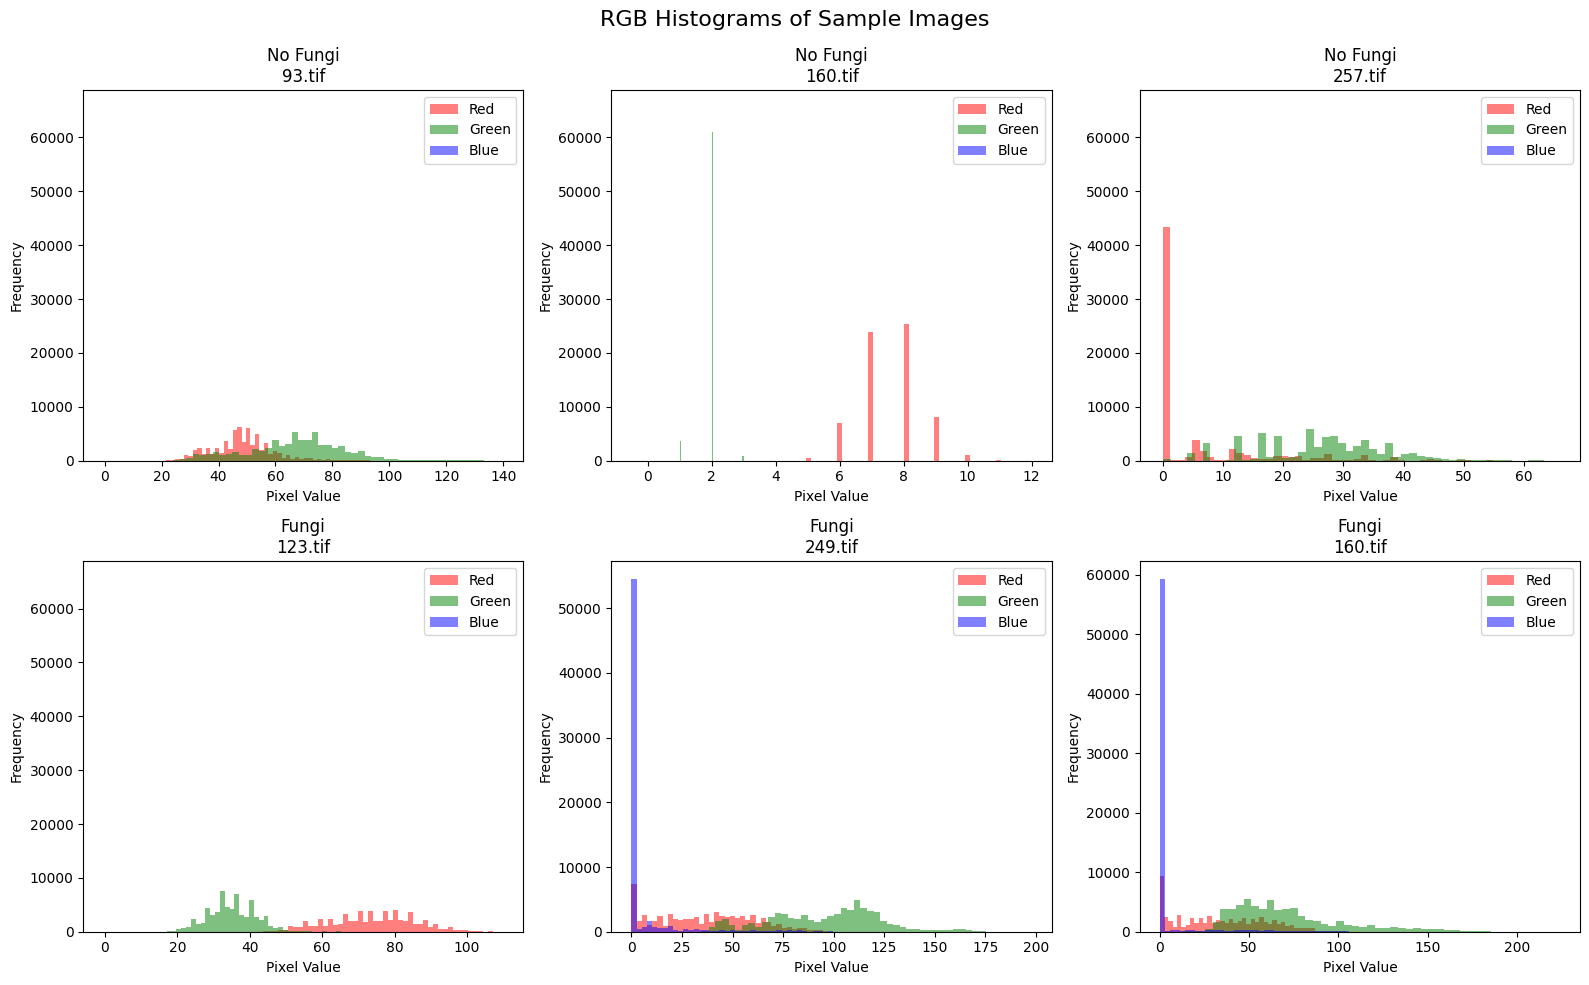

In [ ]:
print("\nPlotting color histograms...")
plot_color_histograms(data_dir, num_samples=3)

In [ ]:
# Custom dataset class to load TIF images
class FungiDataset:
    def __init__(self, data_dir):
        self.data_dir = Path(data_dir)
        self.images = []
        self.labels = []
        self.label_map = {'No Fungi': 0, 'Fungi': 1}

        # Load all images and labels
        for label in self.label_map.keys():
            label_dir = self.data_dir / label
            for img_path in label_dir.glob('*.tif'):
                self.images.append(str(img_path))
                self.labels.append(self.label_map[label])

    def to_huggingface_dataset(self):
        # Convert to HuggingFace dataset format
        def load_image(path):
            with Image.open(path) as img:
                # Convert to RGB as ViT expects 3 channels
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                return img

        dataset_dict = {
            'img': [load_image(path) for path in self.images],
            'label': self.labels
        }

        features = Features({
            'img': HFImage(),
            'label': ClassLabel(names=['No Fungi', 'Fungi'])
        })

        return Dataset.from_dict(dataset_dict, features=features)

In [ ]:
# Function to preprocess images for ViT
def preprocess(batch, feature_extractor):
    inputs = feature_extractor(
        batch['img'],
        return_tensors='pt'
    )
    inputs['label'] = batch['label']
    return inputs

# Collate function for batching
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

# Enhanced compute metrics function with F1 score
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    references = eval_pred.label_ids

    # Calculate metrics
    accuracy_metric = load_metric("accuracy")
    accuracy = accuracy_metric.compute(predictions=predictions, references=references)

    # Calculate F1 score
    f1 = f1_score(references, predictions, average='weighted')

    # Get detailed classification report
    report = classification_report(references, predictions,
                                 target_names=['No Fungi', 'Fungi'],
                                 output_dict=True)

    # Return all metrics
    return {
        'accuracy': accuracy['accuracy'],
        'f1_score': f1,
        'f1_no_fungi': report['No Fungi']['f1-score'],
        'f1_fungi': report['Fungi']['f1-score'],
        'precision_no_fungi': report['No Fungi']['precision'],
        'precision_fungi': report['Fungi']['precision'],
        'recall_no_fungi': report['No Fungi']['recall'],
        'recall_fungi': report['Fungi']['recall']
    }

def train_fungi_classifier(data_dir, output_dir="./fungi_model", num_epochs=4):
    # Load and prepare datasets
    dataset = FungiDataset(data_dir)
    full_dataset = dataset.to_huggingface_dataset()

    # Split into train and test
    full_dataset = full_dataset.shuffle(seed=42)
    split_dataset = full_dataset.train_test_split(test_size=0.2)

    # Load ViT feature extractor
    model_id = 'google/vit-base-patch16-224-in21k'
    feature_extractor = ViTFeatureExtractor.from_pretrained(model_id)

    # Prepare datasets
    def preprocess_function(batch):
        return preprocess(batch, feature_extractor)

    prepared_train = split_dataset['train'].with_transform(preprocess_function)
    prepared_test = split_dataset['test'].with_transform(preprocess_function)

    # Training arguments
    training_args = TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=16,
        evaluation_strategy="steps",
        num_train_epochs=num_epochs,
        save_steps=100,
        eval_steps=100,
        logging_steps=10,
        learning_rate=2e-4,
        save_total_limit=2,
        remove_unused_columns=False,
        push_to_hub=False,
        load_best_model_at_end=True,
    )
    training_args = TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=16,
        evaluation_strategy="epoch",     # Changed to epoch
        save_strategy="epoch",          # Changed to match evaluation_strategy
        num_train_epochs=num_epochs,
        logging_steps=10,
        learning_rate=2e-4,
        save_total_limit=2,
        remove_unused_columns=False,
        push_to_hub=False,
        load_best_model_at_end=True,
    )
    # Load model
    model = ViTForImageClassification.from_pretrained(
        model_id,
        num_labels=2,  # Binary classification
        ignore_mismatched_sizes=True
    )

    # Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=collate_fn,
        compute_metrics=compute_metrics,
        train_dataset=prepared_train,
        eval_dataset=prepared_test,
        tokenizer=feature_extractor,
    )

    # Train model
    train_results = trainer.train()

    # Save model and evaluate
    trainer.save_model()
    metrics = trainer.evaluate(prepared_test)

    return trainer, metrics

In [ ]:
import wandb
wandb.login(key="<wandb_key>")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ganesh-stemx. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb.init(project="vt_001")

wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250316_172437-ylzhlxeb
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run fanciful-dream-9
wandb: ⭐️ View project at https://wandb.ai/ganesh-stemx/vt_001
wandb: 🚀 View run at https://wandb.ai/ganesh-stemx/vt_001/runs/ylzhlxeb


In [ ]:
# Usage example
if __name__ == "__main__":
    data_dir = "/kaggle/input/an-eye-on-the-vine/an_eye_on_the_vine"
    trainer, metrics = train_fungi_classifier(data_dir)
    print(f"Evaluation metrics: {metrics}")

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-10-f201facfea5f>:102: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,F1 No Fungi,F1 Fungi,Precision No Fungi,Precision Fungi,Recall No Fungi,Recall Fungi
1,0.278400,0.233319,0.909605,0.910074,0.851852,0.934959,0.836364,0.942623,0.867925,0.927419
2,0.257400,0.198598,0.920904,0.921315,0.870370,0.943089,0.854545,0.950820,0.886792,0.935484
3,0.090000,0.143794,0.943503,0.943186,0.903846,0.960000,0.921569,0.952381,0.886792,0.967742
4,0.060900,0.149037,0.949153,0.949541,0.917431,0.963265,0.892857,0.975207,0.943396,0.951613


<ipython-input-10-f201facfea5f>:23: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric("accuracy")


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

Evaluation metrics: {'eval_loss': 0.1437940150499344, 'eval_accuracy': 0.943502824858757, 'eval_f1_score': 0.9431855714906562, 'eval_f1_no_fungi': 0.9038461538461539, 'eval_f1_fungi': 0.96, 'eval_precision_no_fungi': 0.9215686274509803, 'eval_precision_fungi': 0.9523809523809523, 'eval_recall_no_fungi': 0.8867924528301887, 'eval_recall_fungi': 0.967741935483871, 'eval_runtime': 2.4901, 'eval_samples_per_second': 71.081, 'eval_steps_per_second': 4.819, 'epoch': 4.0}
